# Binary-Class Image Classification Deep Learning Model for Meat Quality Assessment Using TensorFlow Take 4
### David Lowe
### December 2, 2021

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: This project aims to construct a predictive model using a TensorFlow convolutional neural network (CNN) and document the end-to-end steps using a template. The Meat Quality Assessment dataset is a binary classification situation where we attempt to predict one of two possible outcomes.

INTRODUCTION: The research team collected the dataset to develop a meat quality assessment system based on deep learning. The published paper explains all of the experimental results, proving the usability of the dataset and model. This dataset contains fresh and spoiled red meat samples from a supermarket in Izmir, Turkey, for a university-industry collaboration project at the Izmir University of Economics.

For this modeling project, we will predict whether an image represents a fresh or spoiled meat case. In this iteration, we will construct a CNN model based on the EfficientNetB5 architecture to make predictions.

ANALYSIS: In this iteration, the EfficientNetB5 model's performance achieved an accuracy score of 94.86% after 10 epochs using the training dataset. The same model processed the validation dataset with an accuracy rate of 98.68%.

CONCLUSION: In this iteration, the EfficientNetB5-based CNN model appeared to be suitable for modeling this dataset. We should consider experimenting with TensorFlow for further modeling.

Dataset Used: Meat Quality Assessment

Dataset ML Model: Binary classification with numerical attributes

Dataset Reference: https://www.kaggle.com/crowww/meat-quality-assessment-based-on-deep-learning

One potential source of performance benchmarks: https://ieeexplore.ieee.org/abstract/document/8946388

A deep-learning image classification project generally can be broken down into five major tasks:

1. Prepare Environment
2. Load and Prepare Images
3. Define and Train Models
4. Evaluate and Optimize Models
5. Finalize Model and Make Predictions

# Task 1 - Prepare Environment

In [1]:
# Install the packages to support accessing environment variable and SQL databases
# !pip install python-dotenv PyMySQL boto3

In [2]:
# Retrieve GPU configuration information from Colab
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Tue Nov 30 18:52:33 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    48W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Retrieve memory configuration information from Colab
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
    print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
    print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
    print('re-execute this cell.')
else:
    print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [4]:
# Retrieve CPU information from the system
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 8


## 1.a) Load libraries and modules

In [5]:
# Set the random seed number for reproducible results
RNG_SEED = 88

In [6]:
# Load libraries and packages
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import sys
from datetime import datetime
import zipfile
import h5py
# import boto3
# from dotenv import load_dotenv
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

## 1.b) Set up the controlling parameters and functions

In [7]:
# Begin the timer for the script processing
start_time_script = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
N_JOBS = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
NOTIFY_STATUS = False

# Set the percentage sizes for splitting the dataset
VAL_SET_RATIO = 0.2
# TEST_SET_RATIO = 0.5

# Set various default modeling parameters
DEFAULT_LOSS = 'binary_crossentropy'
DEFAULT_METRICS = ['accuracy']
DEFAULT_OPTIMIZER = tf.keras.optimizers.RMSprop(learning_rate=0.000005)
DEFAULT_INITIALIZER = tf.keras.initializers.RandomNormal(seed=RNG_SEED)
CLASSIFIER_ACTIVATION = 'sigmoid'
MAX_EPOCHS = 10
BATCH_SIZE = 8
# RAW_IMAGE_SIZE = (1280, 720)
TARGET_IMAGE_SIZE = (299, 299)
INPUT_IMAGE_SHAPE = (TARGET_IMAGE_SIZE[0], TARGET_IMAGE_SIZE[1], 3)

NUM_CLASSES = 1  # 1 for binary classification
CLASS_LABELS = ['Fresh','Spoiled']
# CLASS_NAMES = []

# Define the labels to use for graphing the data
train_metric = "accuracy"
validation_metric = "val_accuracy"
train_loss = "loss"
validation_loss = "val_loss"

# Define the directory locations and file names
STAGING_DIR = 'staging/'
TRAIN_DIR = 'staging/'
# VALID_DIR = ''
# TEST_DIR = ''
TRAIN_DATASET = 'kaggle-meat-quality-assessment.zip'
# VALID_DATASET = ''
# TEST_DATASET = ''
# TRAIN_LABELS = ''
# VALID_LABELS = ''
# TEST_LABELS = ''
# OUTPUT_DIR = 'staging/'
# SAMPLE_SUBMISSION_CSV = 'sample_submission.csv'
# FINAL_SUBMISSION_CSV = 'submission.csv'

# Check the number of GPUs accessible through TensorFlow
print('Number of GPUs detected by TensorFlow:', len(tf.config.list_physical_devices('GPU')))

# Print out the TensorFlow version for confirmation
print('TensorFlow version:', tf.__version__)

Number of GPUs detected by TensorFlow: 1
TensorFlow version: 2.7.0


In [8]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [9]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 1 - Prepare Environment has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [10]:
# Reset the random number generators
def reset_random(x=RNG_SEED):
    random.seed(x)
    np.random.seed(x)
    tf.random.set_seed(x)

In [11]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 1 - Prepare Environment completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 2 - Load and Prepare Images

In [12]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 2 - Load and Prepare Images has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [13]:
# Create a staging directory to hold all images
!rm -rf staging/
!mkdir staging/

In [14]:
if not os.path.exists(TRAIN_DATASET):
    !wget https://dainesanalytics.com/datasets/kaggle-meat-quality-assessment/kaggle-meat-quality-assessment.zip

In [15]:
zip_ref = zipfile.ZipFile(TRAIN_DATASET, 'r')
zip_ref.extractall(STAGING_DIR)
zip_ref.close()

In [16]:
# Brief listing of training image files for each class
for c_label in CLASS_LABELS:
    training_class_dir = os.path.join(TRAIN_DIR, c_label)
    training_class_files = os.listdir(training_class_dir)
    print('Number of training images for', c_label, ':', len(os.listdir(training_class_dir)))
    print('Training samples for', c_label, ':')
    print(training_class_files[:5],'\n')

Number of training images for Fresh : 948
Training samples for Fresh :
['test_20171016_170321D.jpg', 'test_20171016_234121D.jpg', 'test_20171016_142121D.jpg', 'test_20171017_181721D.jpg', 'test_20171016_233321D.jpg'] 

Number of training images for Spoiled : 948
Training samples for Spoiled :
['test_20171018_090321D.jpg', 'test_20171017_230321D.jpg', 'test_20171018_164921D.jpg', 'test_20171017_204321D.jpg', 'test_20171017_233121D.jpg'] 



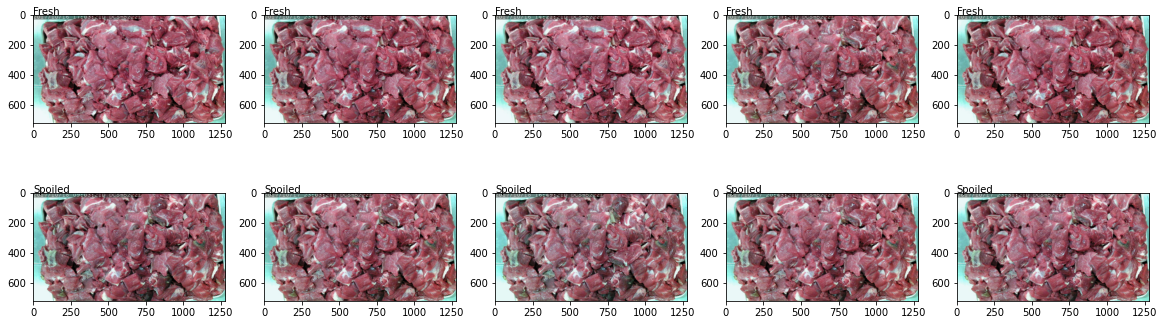

In [17]:
# Plot some training images from the dataset
nrows = 2
ncols = 5
training_examples = []
example_labels = []

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 3)

for c_label in CLASS_LABELS:
    training_class_dir = os.path.join(TRAIN_DIR, c_label)
    training_class_files = os.listdir(training_class_dir)
    for j in range(ncols):
        training_examples.append(training_class_dir + '/' + training_class_files[j])
        example_labels.append(c_label)
    # print(training_examples)
    # print(example_labels)

for i, img_path in enumerate(training_examples):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i+1)
    sp.text(0, 0, example_labels[i])
    # sp.axis('Off')
    img = mpimg.imread(img_path)
    plt.imshow(img)
plt.show()

In [18]:
datagen_kwargs = dict(rescale=1./255, validation_split=VAL_SET_RATIO)
training_datagen = ImageDataGenerator(**datagen_kwargs)
validation_datagen = ImageDataGenerator(**datagen_kwargs)
dataflow_kwargs = dict(class_mode="binary")

do_data_augmentation = True
if do_data_augmentation:
    training_datagen = ImageDataGenerator(rotation_range=90,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          **datagen_kwargs)

print('Loading and pre-processing the training images...')
training_generator = training_datagen.flow_from_directory(directory=TRAIN_DIR,
                                                          target_size=TARGET_IMAGE_SIZE,
                                                          batch_size=BATCH_SIZE,
                                                          shuffle=True,
                                                          seed=RNG_SEED,
                                                          subset="training",
                                                          **dataflow_kwargs)
print('Number of training image batches per epoch of modeling:', len(training_generator))

print('Loading and pre-processing the validation images...')
validation_generator = validation_datagen.flow_from_directory(directory=TRAIN_DIR,
                                                              target_size=TARGET_IMAGE_SIZE,
                                                              batch_size=BATCH_SIZE,
                                                              shuffle=False,
                                                              subset="validation",
                                                              **dataflow_kwargs)
print('Number of validation image batches per epoch of modeling:', len(validation_generator))

Loading and pre-processing the training images...
Found 1518 images belonging to 2 classes.
Number of training image batches per epoch of modeling: 190
Loading and pre-processing the validation images...
Found 378 images belonging to 2 classes.
Number of validation image batches per epoch of modeling: 48


In [19]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 2 - Load and Prepare Images completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 3 - Define and Train Models

In [20]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 3 - Define and Train Models has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [21]:
# Define the function for plotting training results for comparison
def plot_metrics(history):
    fig, axs = plt.subplots(1, 2, figsize=(24, 15))
    metrics =  [train_loss, train_metric]
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color='blue', label='Train')
        plt.plot(history.epoch, history.history['val_'+metric], color='red', linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == train_loss:
            plt.ylim([0, plt.ylim()[1]])
        else:
            plt.ylim([0.5, 1.1])
        plt.legend()

In [22]:
# Define the baseline model for benchmarking
def create_nn_model(input_param=INPUT_IMAGE_SHAPE, output_param=NUM_CLASSES, dense_nodes=2048,
                    init_param=DEFAULT_INITIALIZER, classifier_activation=CLASSIFIER_ACTIVATION,
                    loss_param=DEFAULT_LOSS, opt_param=DEFAULT_OPTIMIZER, metrics_param=DEFAULT_METRICS):
    base_model = keras.applications.efficientnet.EfficientNetB5(include_top=False, weights='imagenet', input_shape=input_param)
    nn_model = keras.models.Sequential()
    nn_model.add(base_model)
    nn_model.add(keras.layers.Flatten())
    nn_model.add(keras.layers.Dense(dense_nodes, activation='relu', kernel_initializer=init_param)),
    nn_model.add(keras.layers.Dense(output_param, activation=classifier_activation))
    nn_model.compile(loss=loss_param, optimizer=opt_param, metrics=metrics_param)
    return nn_model

In [23]:
# Initialize the neural network model and get the training results for plotting graph
start_time_module = datetime.now()
reset_random()
tf.keras.backend.clear_session()
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.000001)
nn_model_0 = create_nn_model()
nn_model_history = nn_model_0.fit(training_generator,
                                  epochs=MAX_EPOCHS,
                                  validation_data=validation_generator,
                                #   callbacks=[learning_rate_reduction],
                                  verbose=1)
print('Total time for model fitting:', (datetime.now() - start_time_module))

Epoch 1/10
190/190 [==============================] - 104s 367ms/step - loss: 2.2342 - accuracy: 0.7424 - val_loss: 10.3683 - val_accuracy: 0.5000
Epoch 2/10
190/190 [==============================] - 66s 346ms/step - loss: 1.1923 - accuracy: 0.8564 - val_loss: 0.5663 - val_accuracy: 0.6799
Epoch 3/10
190/190 [==============================] - 66s 346ms/step - loss: 1.0317 - accuracy: 0.8775 - val_loss: 6.4520 - val_accuracy: 0.5026
Epoch 4/10
190/190 [==============================] - 66s 347ms/step - loss: 0.7058 - accuracy: 0.9144 - val_loss: 0.4486 - val_accuracy: 0.8836
Epoch 5/10
190/190 [==============================] - 66s 347ms/step - loss: 0.6936 - accuracy: 0.9190 - val_loss: 0.3193 - val_accuracy: 0.9630
Epoch 6/10
190/190 [==============================] - 66s 346ms/step - loss: 0.6807 - accuracy: 0.9242 - val_loss: 0.6040 - val_accuracy: 0.9048
Epoch 7/10
190/190 [==============================] - 66s 346ms/step - loss: 0.6030 - accuracy: 0.9295 - val_loss: 0.2770 - val_

In [24]:
nn_model_0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb5 (Functional)  (None, 10, 10, 2048)     28513527  
                                                                 
 flatten (Flatten)           (None, 204800)            0         
                                                                 
 dense (Dense)               (None, 2048)              419432448 
                                                                 
 dense_1 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 447,948,024
Trainable params: 447,775,281
Non-trainable params: 172,743
_________________________________________________________________


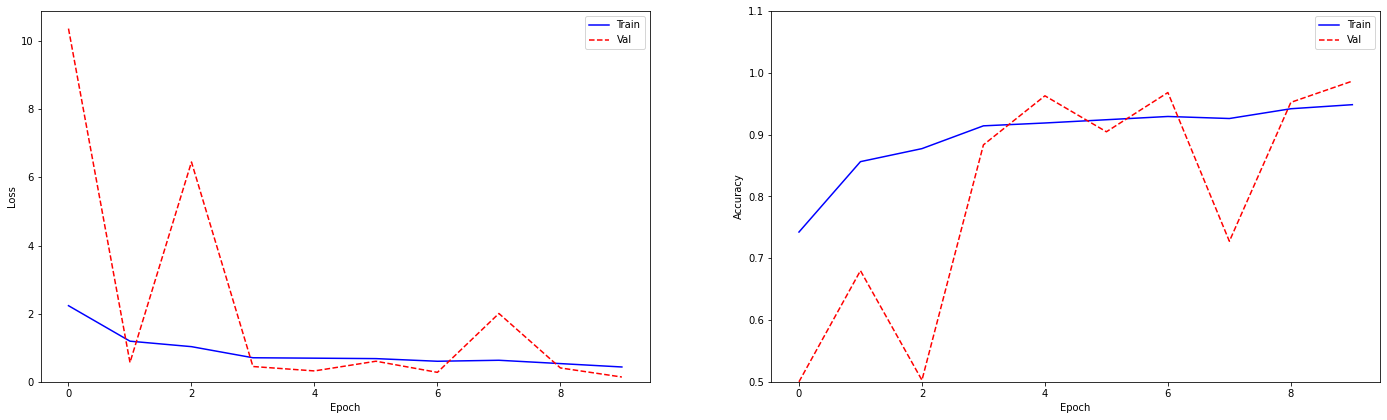

In [25]:
plot_metrics(nn_model_history)

In [26]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 3 - Define and Train Models completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 4 - Evaluate and Optimize Models

In [27]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 4 - Evaluate and Optimize Models has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [28]:
# Not applicable for this iteration of modeling

In [29]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 4 - Evaluate and Optimize Models completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 5 - Finalize Model and Make Predictions

In [30]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 5 - Finalize Model and Make Predictions has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [31]:
# Not applicable for this iteration of modeling

In [32]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 5 - Finalize Model and Make Predictions completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [33]:
print ('Total time for the script:',(datetime.now() - start_time_script))

Total time for the script: 0:11:49.856965
